In [1]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse
import heartpy as hp
import os
import pickle
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [2]:
def plt_performance(history, path='./', filename=''):
    epoch = list(range(0,len(history.history['loss'])))
    
    fig, (his_accuracy, his_loss) = plt.subplots(nrows=2,ncols=1,figsize=(10,8),sharex=True)
    his_loss.plot(epoch, history.history['loss'], label='Training loss')
    his_loss.plot(epoch, history.history['val_loss'], label='Validation loss')
    his_loss.set_xlabel("Epochs", fontsize=14)
    his_loss.set_ylabel("Loss", fontsize=14)
    his_loss.set_title("Loss", fontsize=14)
    his_loss.legend(loc='best')
    
    his_accuracy.plot(epoch, history.history['acc'], label='Training accuracy')
    his_accuracy.plot(epoch, history.history['val_acc'], label='Validation accuracy')
    his_accuracy.set_xlabel("Epochs", fontsize=14)
    his_accuracy.set_ylabel("Accuracy", fontsize=14)
    his_accuracy.set_title("Accuracy", fontsize=14)
    his_accuracy.legend(loc='best')
    
    fig.tight_layout()
    if filename == '':
        plt.savefig(f'{path}/performance.png', bbox_inches='tight')
    else:
        plt.savefig(f'{path}/{filename}.png', bbox_inches='tight')
        

def preprocessing(PPG_data):
    index = 0
    x = list(range(0,len(PPG_data[0])))
    for PPG in PPG_data:
        poly = np.polyfit(x, PPG, deg=50)
        polied = np.polyval(poly, x)
        detrended = PPG - polied
        PPG_data[index] = detrended
        index += 1
    return PPG_data
    

In [3]:
dir_list_ = os.listdir("./data")
dir_list_.sort()
count = 0
dir_list = []
# dir_list_.pop(0)
dir_list = dir_list_

df_PPG = pd.DataFrame(columns=['participant','video_number','ppg','valence','arousal'])

file_num = 0
for file in dir_list:
    dat_file = f'./data/{file}'
    with open(dat_file, 'rb') as f:
        Channel_data = pickle.load(f,encoding='latin1')
    data = Channel_data["data"]
    labels = Channel_data["labels"]
    for video_num in range(40):
        dataP = data[video_num,38]
        dataP = dataP[384:]
        
        label = labels[video_num]
        if label[0] < 5:
            Valence = 0
        if label[0] >= 5:
            Valence = 1
        if label[1] < 5:
            Arousal = 0
        if label[1] >= 5:
            Arousal = 1
        instance = [(file_num, video_num, dataP, Valence, Arousal)]
        new_instance = pd.DataFrame(instance, columns=['participant','video_number','ppg','valence','arousal'])
        df_PPG = pd.concat([df_PPG, new_instance], ignore_index = True)
    
    file_num += 1

In [4]:
PPG_data = df_PPG['ppg']
Valence = df_PPG['valence']
Arousal = df_PPG['arousal']

In [5]:
preprocessed = preprocessing(PPG_data)

/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/numpy/lib/polynomial.py:627: RuntimeWarning: overflow encountered in multiply
  scale = NX.sqrt((lhs*lhs).sum(axis=0))
/home/sselab/anaconda3/envs/EmotionRecognition/lib/python3.8/site-packages/numpy/core/_methods.py:47: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [6]:
num_video = 12
preprocessed = preprocessed[:-40*num_video]
Valence = Valence[:-40*num_video]
Arousal = Arousal[:-40*num_video]

In [7]:
from sklearn.preprocessing import MinMaxScaler

# window = 1280
timestep = 1280
segmented = []
valence_data = []
arousal_data = []
################################################
preprocessed = np.array(preprocessed)
idx = 0
normalized = []
print(preprocessed.shape)
tmp = []
for pre in preprocessed:
    tmp.append(pre)
    if idx == 39:
        scaler = MinMaxScaler(feature_range=(0,1))
        norm = scaler.fit_transform(tmp) * 1000
        normalized.append(norm)
        print(len(norm), len(tmp))
        idx = -1
        tmp = []
    idx += 1
    count += 1

print(len(normalized), len(normalized[0]))

(800,)
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
40 40
20 40


In [8]:
data = []
for i in normalized:
    for j in i:
        data.append(j)

In [9]:
print(len(data))

800


In [10]:
print(len(data))
idx = 0
for PPG in data:
    for index in range(0, len(PPG) - timestep, 128):
        segmented.append(PPG[index : index + timestep])
        valence_data.append(Valence[idx])
        arousal_data.append(Arousal[idx])
    idx += 1

800


In [11]:
import tensorflow as tf
tf.config.experimental_run_functions_eagerly(True)
from tensorflow import keras
from tensorflow.keras import layers, callbacks
# from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.layers import Dense, Flatten, Dropout,BatchNormalization
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [12]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 2 GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6000)]) # limit in megabytes
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [13]:
print(len(segmented))

40000


In [14]:
train_x = segmented
train_valence = valence_data
train_arousal = arousal_data

In [15]:
x_train_data = np.array(train_x)
y_train_data = np.array(train_valence).astype(np.float32)
print(x_train_data.shape, y_train_data.shape)

X_train = x_train_data.reshape((x_train_data.shape[0], x_train_data.shape[1], 1))
# X_train = x_train_data.reshape((x_train_data.shape[0], x_train_data.shape[1],1))
Y_train = y_train_data.reshape((y_train_data.shape[0],1))

print(f"X_train shape : {X_train.shape}, Y_train shape : {Y_train.shape}")

(40000, 1280) (40000,)
X_train shape : (40000, 1280, 1), Y_train shape : (40000, 1)


In [16]:
# Set Hyperparameters of the model
learning_rate = 0.0001
epochs = 100
batch_size=128

In [17]:
from tensorflow.keras.layers import LSTM, GRU


# one GRU layers with three dense layers-> IT WORKS !
model = Sequential()
model.add(GRU(units=256,
              dropout=0.25,
              recurrent_dropout=0.25,
              return_sequences=False,
              input_shape=X_train[0].shape))

# Dense net
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='BinaryClassification_Dense3-callback.h5', monitor='val_accuracy', save_best_only=True),
                tf.keras.callbacks.EarlyStopping(patience=10)]

model.compile(loss='binary_crossentropy', optimizer=Adam(lr=learning_rate), metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 256)               198912    
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 462,081
Trainable params: 462,081
Non-trainable params: 0
__________________________________________________

In [18]:
history=model.fit(X_train,
                  Y_train,
                  epochs=epochs,
                  batch_size=batch_size,
                  validation_split=0.2,
                  callbacks=callback_list,
                  shuffle=True,
                  verbose=1)

Epoch 1/100
250/250 [==============================] - 2563s 10s/step - loss: 0.6970 - acc: 0.5211 - val_loss: 0.6840 - val_acc: 0.5875
Epoch 2/100
250/250 [==============================] - 2521s 10s/step - loss: 0.6934 - acc: 0.5254 - val_loss: 0.6905 - val_acc: 0.5393
Epoch 3/100
250/250 [==============================] - 2513s 10s/step - loss: 0.6914 - acc: 0.5309 - val_loss: 0.6808 - val_acc: 0.5875
Epoch 4/100
250/250 [==============================] - 2518s 10s/step - loss: 0.6911 - acc: 0.5332 - val_loss: 0.6829 - val_acc: 0.5875
Epoch 5/100
250/250 [==============================] - 2516s 10s/step - loss: 0.6909 - acc: 0.5343 - val_loss: 0.6871 - val_acc: 0.5875
Epoch 6/100
250/250 [==============================] - 2535s 10s/step - loss: 0.6904 - acc: 0.5365 - val_loss: 0.6904 - val_acc: 0.5274
Epoch 7/100
250/250 [==============================] - 2526s 10s/step - loss: 0.6906 - acc: 0.5350 - val_loss: 0.6828 - val_acc: 0.5875
Epoch 8/100
250/250 [===========================

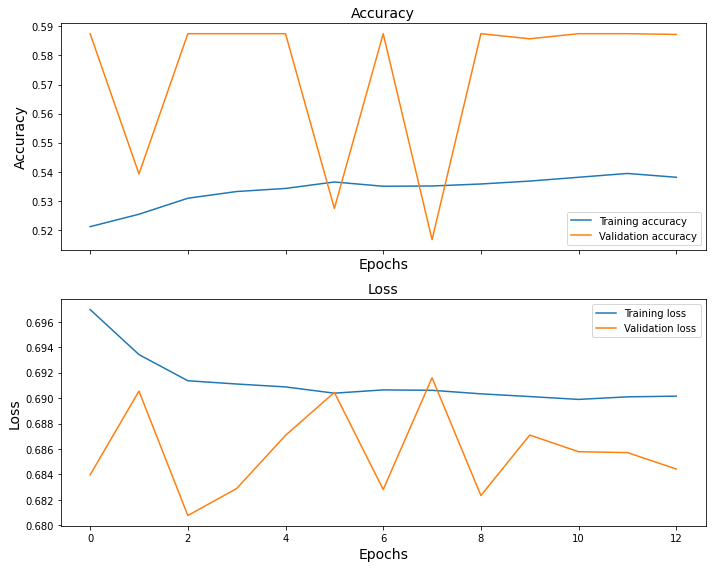

In [19]:
plt_performance(history,path='./plot_performance',filename='GRU_performance0514(2)')